# Life Insurance Risk Prediction

# Business Context


Companies that underwrite life insurance policies have to evaluate applications carefully.
The payouts from life insurance claims are very high relative to the insurance premiums that companies collect from an individual customer. For example, a person who purchases a 500ayear,1 million sum-assured 40-year term plan would be paying 20,000 over 40years but in case if a claim arises,the insurance company would have to pay 1 million to the dependents of this individual. So the company has to be selective about people whom it chooses to insure to keep its business financially viable.



So the business context of this data science problem is that we seek to significantly reduce the processing time involved in the issuance of a life insurance application and save costs for the company through greater automation while making sure that the accuracy of risk assessment is not compromised.


# Business Objective

The main business objective of life insurance risk prediction is:
If the application having high risk,It might be possible company will reject the application.
and application having low risk definitely company will accept the application.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading CSV file
df_train=pd.read_csv('lifeinsurance.csv')

In [3]:
df_train

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,1,D1,10,0.230769,2,3,1,0.074627,0.709091,...,0,0,0,0,0,0,0,0,0,4
59377,79143,1,D3,26,0.230769,2,3,1,0.432836,0.800000,...,0,0,0,0,0,0,0,0,0,7
59378,79144,1,E1,26,0.076923,2,3,1,0.104478,0.745455,...,0,0,0,0,0,0,0,0,0,8
59379,79145,1,D2,10,0.230769,2,3,1,0.507463,0.690909,...,1,0,0,0,0,0,0,0,0,8


In [4]:
df_train.shape

(59381, 128)

In [5]:
print(f'Train dataset shape is {df_train.shape}')

Train dataset shape is (59381, 128)


In [6]:
df_train.isna().sum()

Id                    0
Product_Info_1        0
Product_Info_2        0
Product_Info_3        0
Product_Info_4        0
                     ..
Medical_Keyword_45    0
Medical_Keyword_46    0
Medical_Keyword_47    0
Medical_Keyword_48    0
Response              0
Length: 128, dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [8]:
df_train['Response'].value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64



# We can see that Class 8 has the highest distribution.Its an imbalance data


# Function to delete columns with 30% missing data

In [9]:
def Per_NA(df,thresh=80):
    df_na=pd.DataFrame(df_train.isnull().sum()*100/len(df_train),columns=['missingvalues'])
    df_na.reset_index(inplace=True,drop=False)
    l1=list(df_na[df_na['missingvalues']>thresh]['index'])
    len(l1)
    print(f'There are {len(l1)} columns in this dataset with 80 % missing values.')
    df_train.drop(l1,axis=1,inplace=True)   
    return df

In [10]:
train=Per_NA(df_train)

There are 3 columns in this dataset with 80 % missing values.


In [11]:
pd.unique(df_train['Id'])

array([    2,     5,     6, ..., 79144, 79145, 79146], dtype=int64)

In [12]:
df_train.shape

(59381, 125)

In [13]:
#Columns with null values 
df_train.columns[df_train.isnull().any()]

Index(['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
       'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3',
       'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1',
       'Medical_History_15'],
      dtype='object')

# Exploratory Data Analysis

In [14]:
basic_col=(df_train.columns[~df_train.columns.str.startswith('Medical') &
           ~df_train.columns.str.startswith('Product')]).tolist()
product_col=(df_train.columns[df_train.columns.str.startswith('Product') ]).tolist()
medical_his_col=(df_train.columns[df_train.columns.str.startswith('Medical_History')]).tolist()
medical_keywords_col=(df_train.columns[df_train.columns.str.startswith('Medical_Keyword')]).tolist()

In [15]:
product_col


['Product_Info_1',
 'Product_Info_2',
 'Product_Info_3',
 'Product_Info_4',
 'Product_Info_5',
 'Product_Info_6',
 'Product_Info_7']

In [16]:
#basic_col

basic_train=df_train[basic_col]
basic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   59381 non-null  int64  
 1   Ins_Age              59381 non-null  float64
 2   Ht                   59381 non-null  float64
 3   Wt                   59381 non-null  float64
 4   BMI                  59381 non-null  float64
 5   Employment_Info_1    59362 non-null  float64
 6   Employment_Info_2    59381 non-null  int64  
 7   Employment_Info_3    59381 non-null  int64  
 8   Employment_Info_4    52602 non-null  float64
 9   Employment_Info_5    59381 non-null  int64  
 10  Employment_Info_6    48527 non-null  float64
 11  InsuredInfo_1        59381 non-null  int64  
 12  InsuredInfo_2        59381 non-null  int64  
 13  InsuredInfo_3        59381 non-null  int64  
 14  InsuredInfo_4        59381 non-null  int64  
 15  InsuredInfo_5        59381 non-null 

In [17]:
basic_train.iloc[:,5:11]

,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6
0,0.028,12,1,0.00000,3,NaN
1,0.000,1,3,0.00000,2,0.0018
2,0.030,9,1,0.00000,2,0.0300
3,0.042,9,1,0.00000,3,0.2000
4,0.027,9,1,0.00000,2,0.0500
...,...,...,...,...,...,...
59376,0.020,1,3,0.00000,3,0.0250
59377,0.100,9,1,0.00001,2,0.3500
59378,0.035,9,1,0.00000,2,NaN
59379,0.038,9,1,NaN,3,NaN


# Target Distribution

In [18]:
#univariate analysis of response variable

Text(0, 0.5, 'Count')

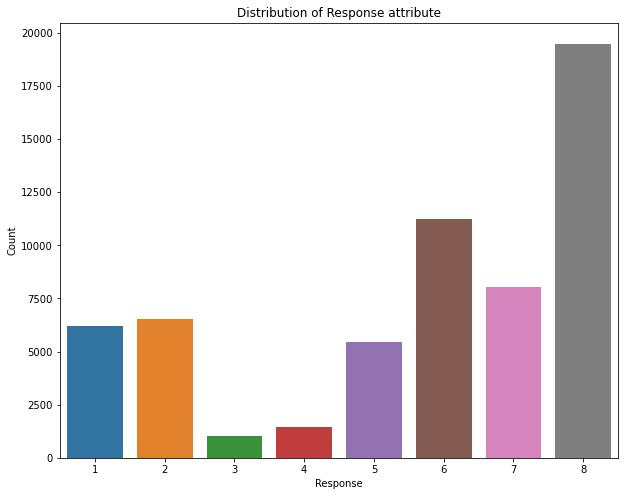

In [19]:
plt.figure(figsize=(10,8))
sns.countplot(x='Response',data=df_train)
plt.title('Distribution of Response attribute')
plt.xlabel('Response')
plt.ylabel('Count')

Text(2.534305555555555, 0.5, 'Frequency')

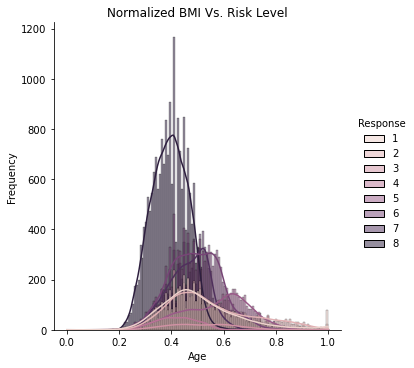

In [20]:
sns.displot(x=basic_train['BMI'],hue=basic_train['Response'],kde=True)
plt.title('Normalized BMI Vs. Risk Level')
plt.xlabel('Age')
plt.ylabel('Frequency')

<AxesSubplot:xlabel='Wt', ylabel='BMI'>

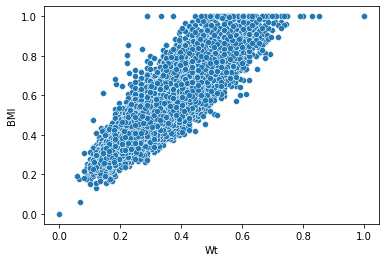

In [21]:
sns.scatterplot(df_train['Wt'],df_train['BMI'])

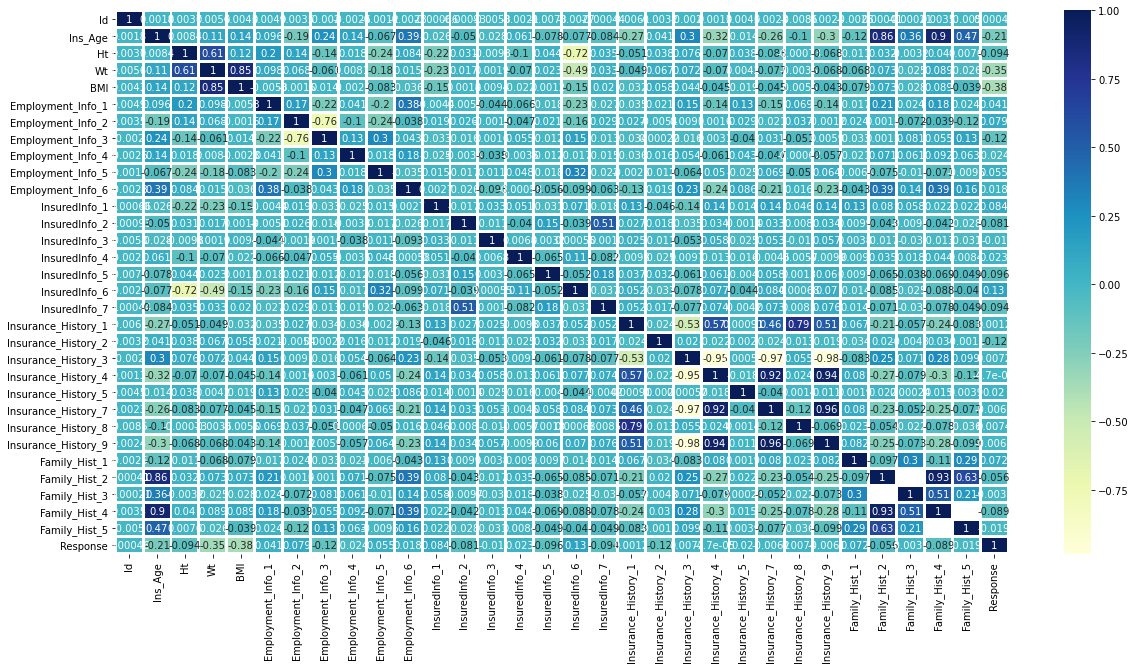

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(data=basic_train.corr(),cmap='YlGnBu',annot=True,linewidths=2)
plt.show()

as per correlation graph the BMI,Family history 2,insurance history 7 and insurance history attribute are highly correlated.

In [23]:
#dropping BMI from original train data
#df_train.drop('BMI',axis=1,inplace=True)

Text(2.534305555555555, 0.5, 'Frequency')

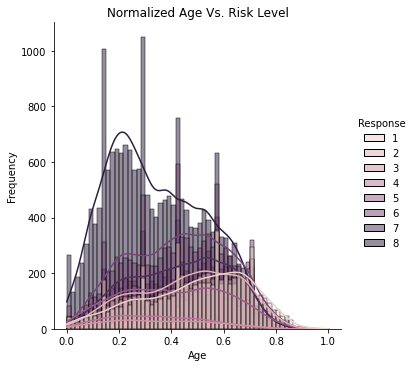

In [24]:
sns.displot(x=basic_train['Ins_Age'],hue=basic_train['Response'],kde=True)
plt.title('Normalized Age Vs. Risk Level')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(2.534305555555555, 0.5, 'Frequency')

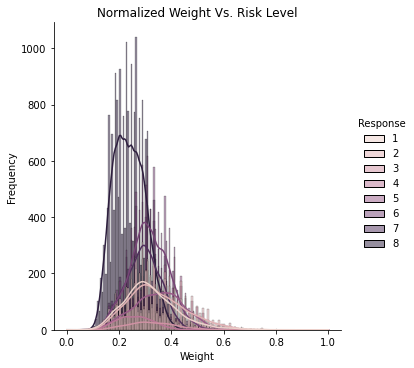

In [25]:
sns.displot(x=basic_train['Wt'],hue=basic_train['Response'],kde=True)
plt.title('Normalized Weight Vs. Risk Level')
plt.xlabel('Weight')
plt.ylabel('Frequency')

Text(2.534305555555555, 0.5, 'Frequency')

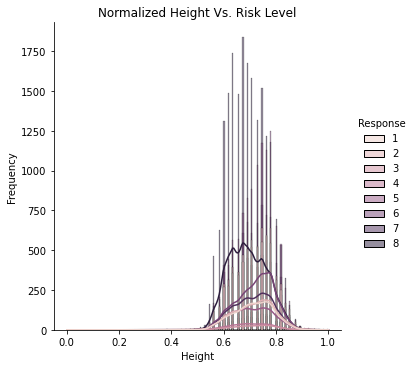

In [26]:
sns.displot(x=basic_train['Ht'],hue=basic_train['Response'],kde=True)
plt.title('Normalized Height Vs. Risk Level')
plt.xlabel('Height')
plt.ylabel('Frequency')



# Distribution of employment info:

In [27]:
#Employment_Info_1-6 : A set of normalized variables relating to the employment history of the applicant.

In [28]:
pd.unique(basic_train['Employment_Info_1'])

array([0.028   , 0.      , 0.03    , ..., 0.051432, 0.02436 , 0.139008])

In [29]:
pd.unique(basic_train['Employment_Info_2'])

array([12,  1,  9, 15,  3, 14, 20, 32, 11, 10, 36, 16, 37, 22,  6, 26, 27,
       13,  2,  4, 35,  7, 38, 30, 18, 29, 19, 31, 21, 23, 34, 25, 33,  5,
       28, 17], dtype=int64)

In [30]:
pd.unique(basic_train['Employment_Info_3'])

array([1, 3], dtype=int64)

Text(0, 0.5, 'Frequency')

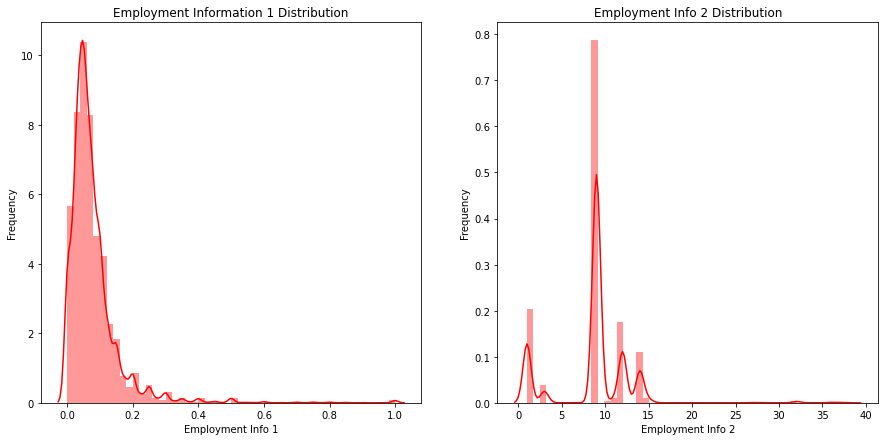

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

sns.distplot(basic_train['Employment_Info_1'], ax=ax[0],color='red')
ax[0].set_title("Employment Information 1 Distribution")
ax[0].set_xlabel("Employment Info 1")
ax[0].set_ylabel("Frequency")

sns.distplot(basic_train['Employment_Info_2'],ax=ax[1],color='red')
ax[1].set_title("Employment Info 2 Distribution")
ax[1].set_xlabel("Employment Info 2")
ax[1].set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

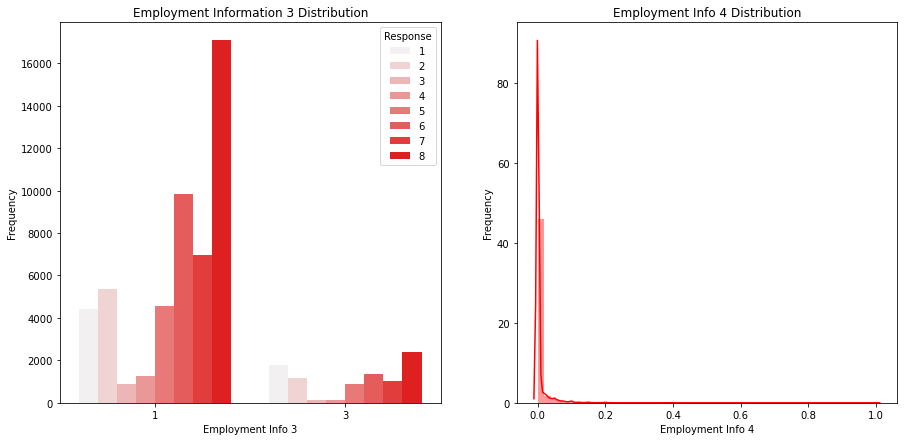

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

sns.countplot(x=basic_train['Employment_Info_3'], hue=basic_train['Response'],ax=ax[0],color='red')
ax[0].set_title("Employment Information 3 Distribution")
ax[0].set_xlabel("Employment Info 3")
ax[0].set_ylabel("Frequency")

sns.distplot(basic_train['Employment_Info_4'],ax=ax[1],color='red')
ax[1].set_title("Employment Info 4 Distribution")
ax[1].set_xlabel("Employment Info 4")
ax[1].set_ylabel("Frequency")

1.Employment information 3 distribution graph shows that there is 2 categories 1 and 3.Category 1 has maximum data with highest risk count almost 17000 compare to category 3. 2.Employment info 4 has numerical data and the data distribution is skewed.

Text(0, 0.5, 'Frequency')

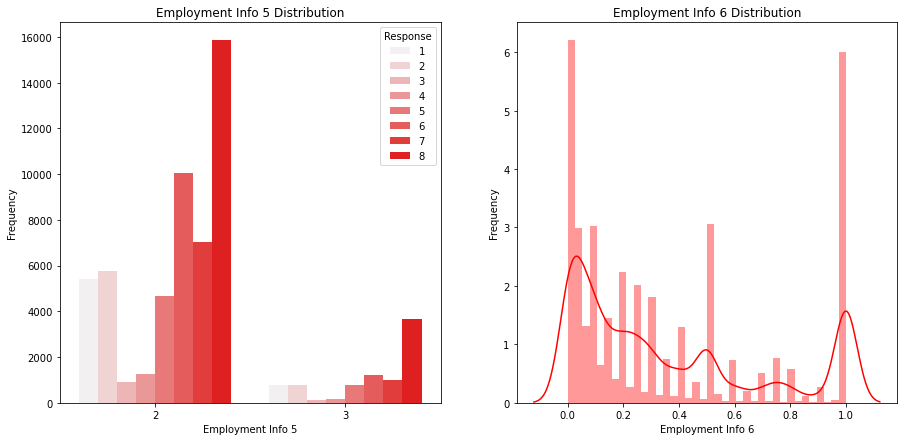

In [33]:
fig, ax = plt.subplots(1,2,figsize=(15,7))


sns.countplot(x=basic_train['Employment_Info_5'], hue=basic_train['Response'],ax=ax[0],color='red')
ax[0].set_title("Employment Info 5 Distribution")
ax[0].set_xlabel("Employment Info 5")
ax[0].set_ylabel("Frequency")

sns.distplot(basic_train['Employment_Info_6'],ax=ax[1],color='red')
ax[1].set_title("Employment Info 6 Distribution")
ax[1].set_xlabel("Employment Info 6")
ax[1].set_ylabel("Frequency")



# Insurance Info_1-7 : A set of normalized variables providing information about the applicant.

In [34]:
pd.unique(basic_train['InsuredInfo_5'])

array([1, 3], dtype=int64)

In [35]:
insured_info_col = (df_train.columns[df_train.columns.str.startswith('InsuredInfo')]).tolist()
insured_info_col

['InsuredInfo_1',
 'InsuredInfo_2',
 'InsuredInfo_3',
 'InsuredInfo_4',
 'InsuredInfo_5',
 'InsuredInfo_6',
 'InsuredInfo_7']

In [36]:
#Univariate Analysis

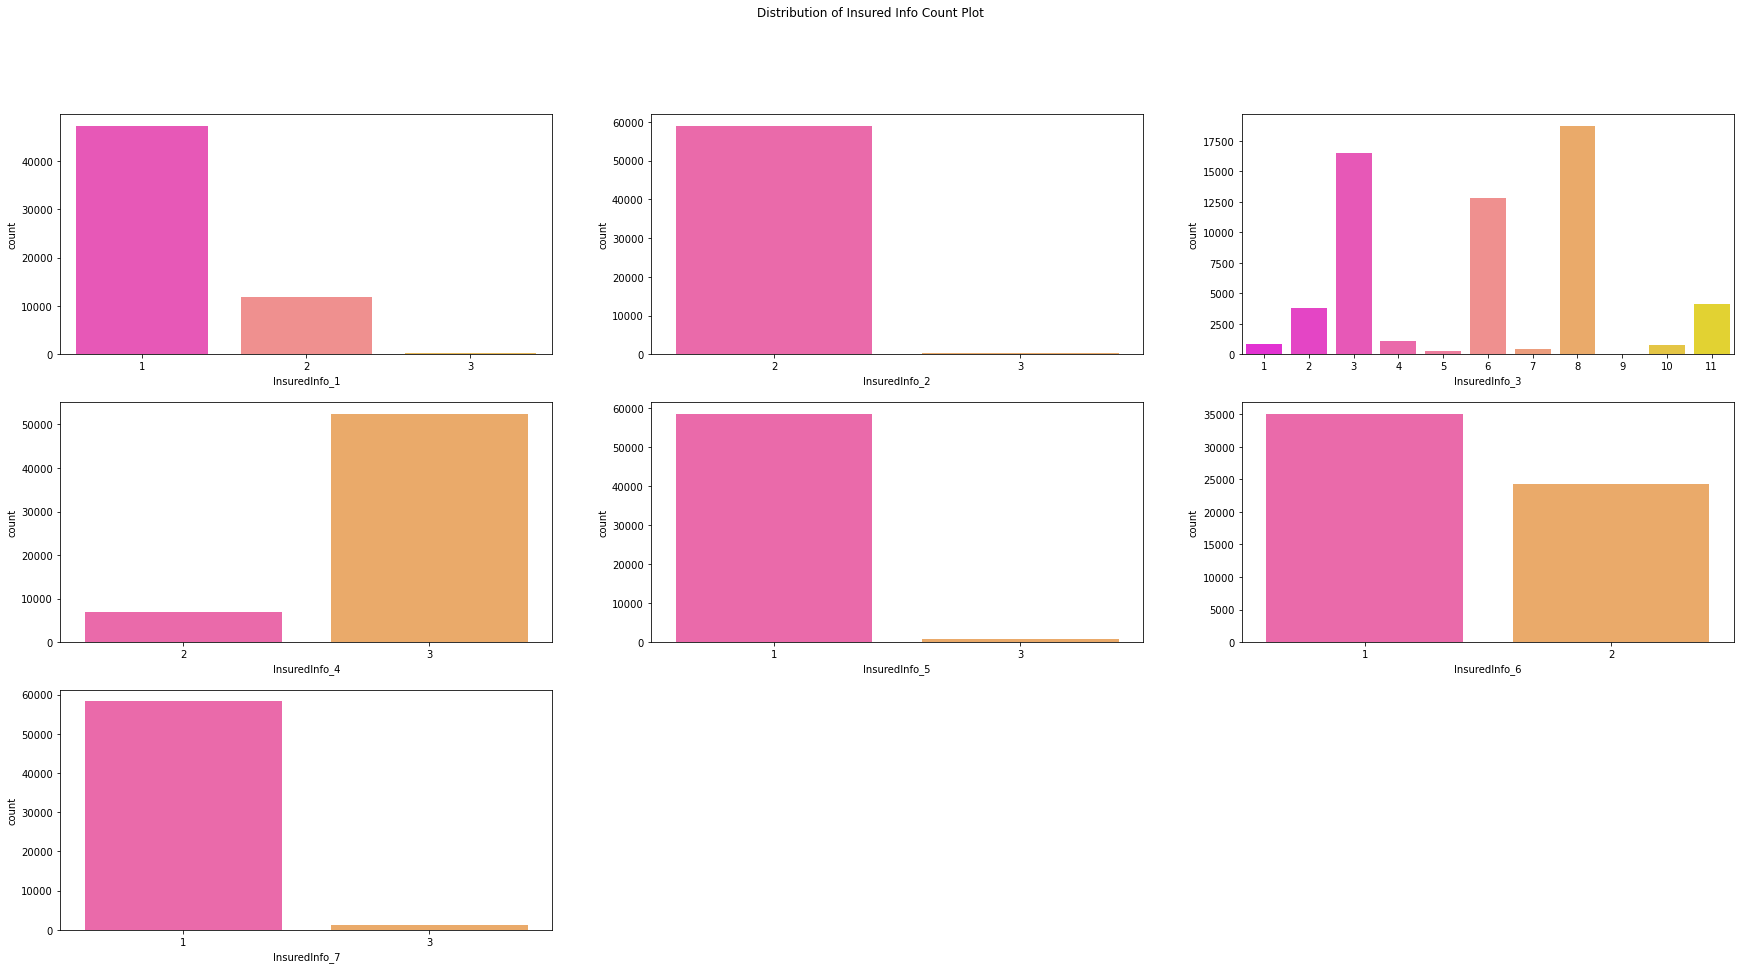

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
for col, an_axes in zip(insured_info_col, ax.flatten()):
    sns.countplot(data=basic_train, x=col, ax=an_axes,palette='spring')
plt.delaxes(ax[2][1])
plt.delaxes(ax[2][2])
plt.suptitle('Distribution of Insured Info Count Plot');

In [38]:
#Bivariate analysis with target variable

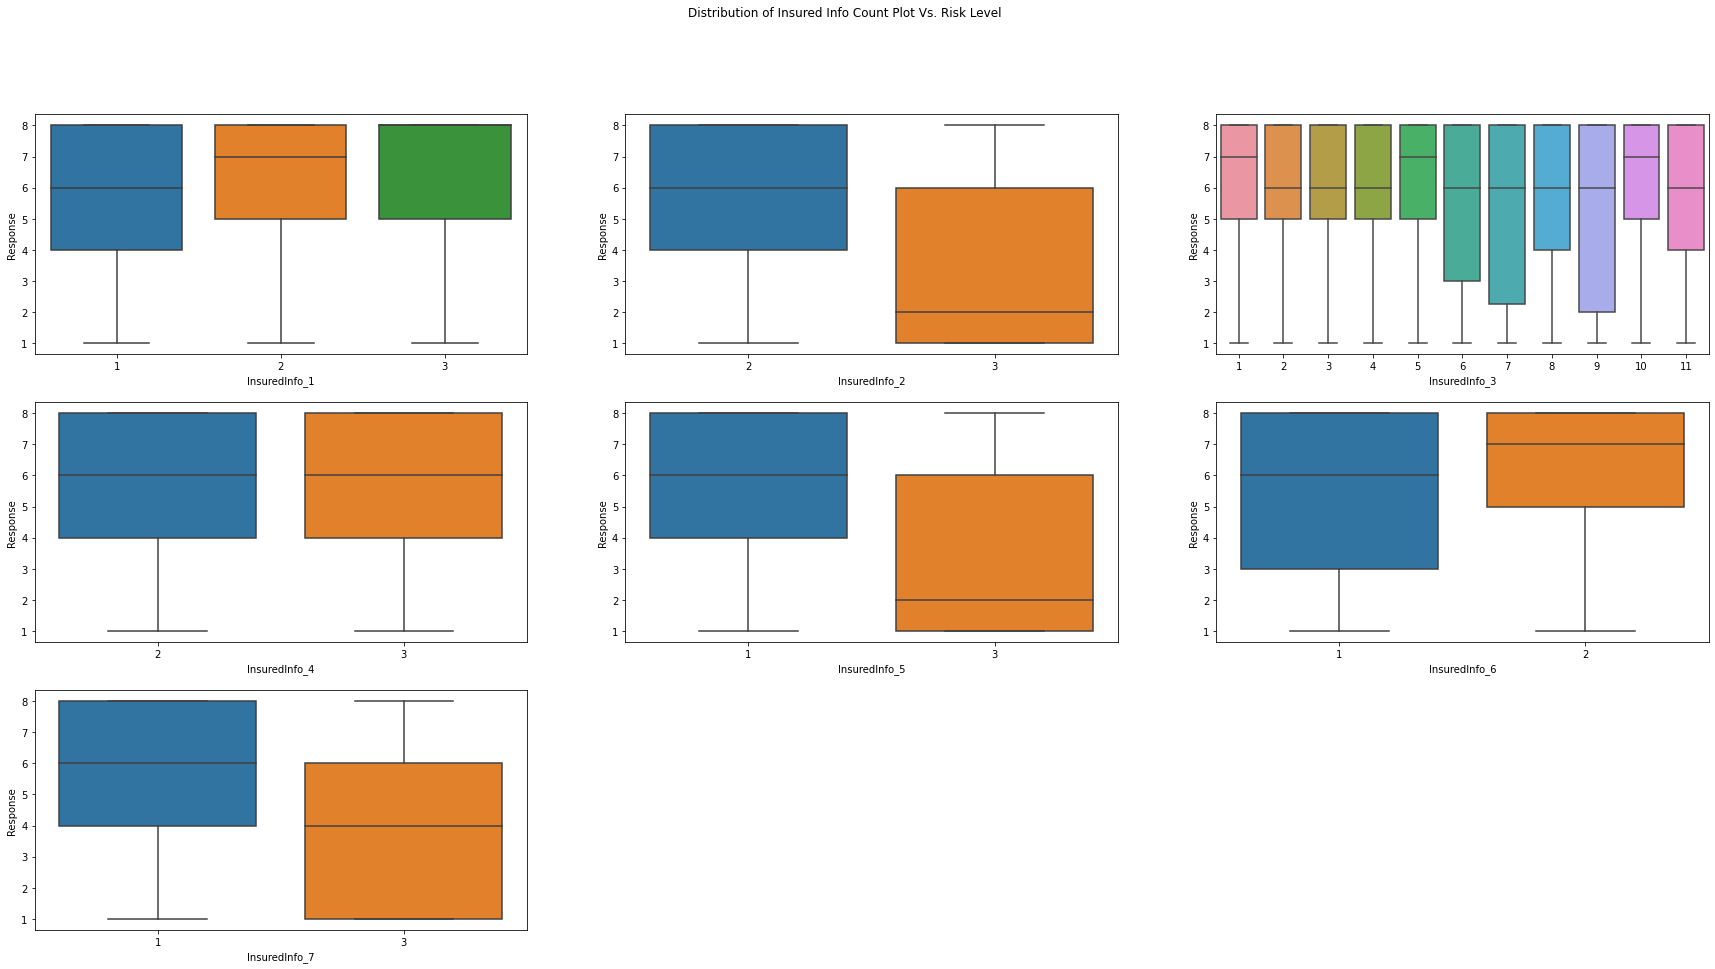

In [39]:
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
for col, an_axes in zip(insured_info_col, ax.flatten()):
    sns.boxplot(data=basic_train, x=col,y='Response',ax=an_axes)
plt.delaxes(ax[2][1])
plt.delaxes(ax[2][2])
plt.suptitle('Distribution of Insured Info Count Plot Vs. Risk Level');

# Insurance History 1-9 : A set of normalized variables relating to the insurance history of the applicant.

# Insurance history contain categorical data.

In [40]:
pd.unique(basic_train['Insurance_History_5'])

array([0.00066667, 0.00013333,        nan, ..., 0.00023414, 0.00574   ,
       0.00137665])

In [41]:
insure_hist_col = (df_train.columns[df_train.columns.str.startswith('Insurance_History')]).tolist()
insure_hist_col

['Insurance_History_1',
 'Insurance_History_2',
 'Insurance_History_3',
 'Insurance_History_4',
 'Insurance_History_5',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9']

In [42]:
##Univariate analysis

Text(0, 0.5, 'Frequency')

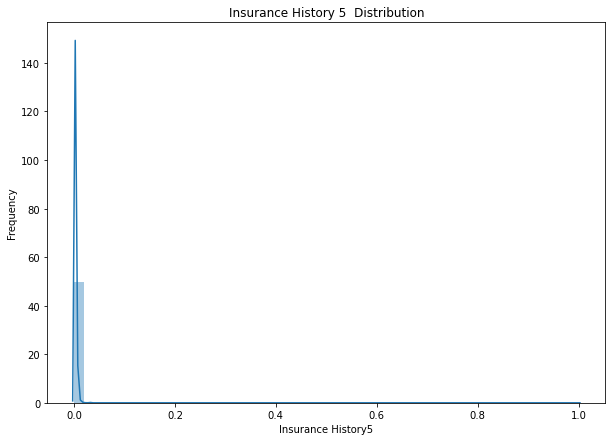

In [43]:
plt.figure(figsize=(10,7))
sns.distplot(basic_train['Insurance_History_5'])
plt.title("Insurance History 5  Distribution")
plt.xlabel("Insurance History5")
plt.ylabel("Frequency")

In [44]:
insure_hist_col=['Insurance_History_1','Insurance_History_2','Insurance_History_3','Insurance_History_4',
                 'Insurance_History_7','Insurance_History_8', 'Insurance_History_9']

In [45]:
##Unnivariate Analysis

Text(0.5, 0.98, 'Distribution of Insured History Count Plot')

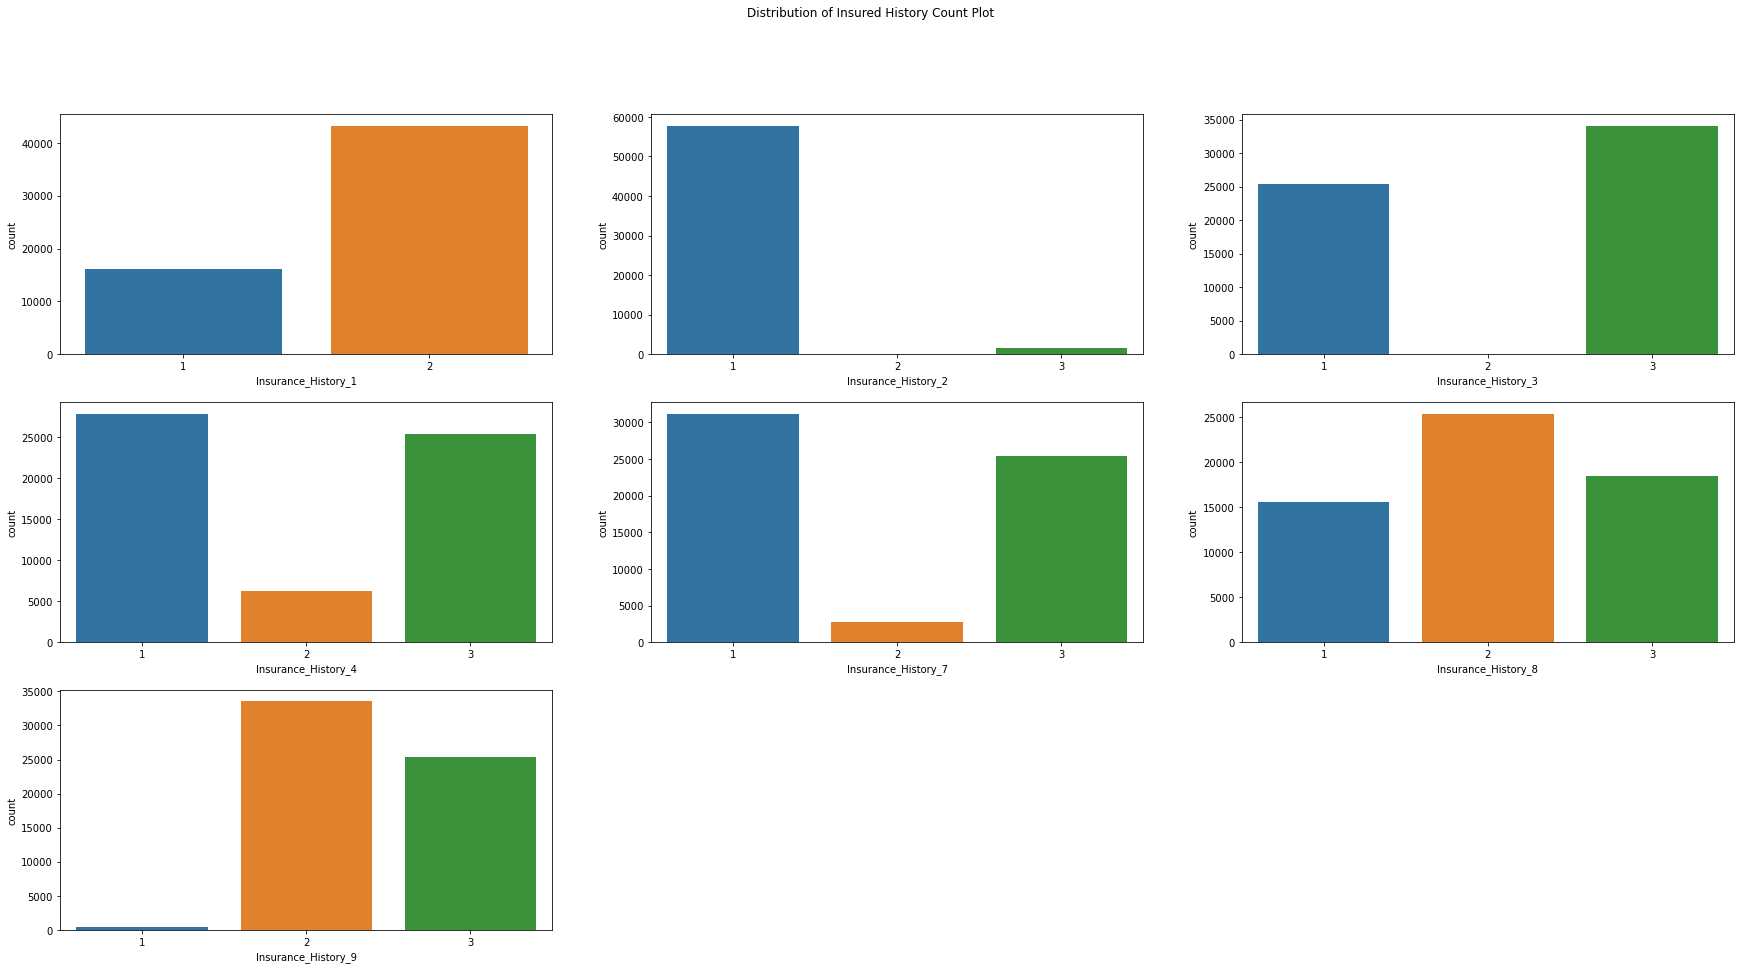

In [46]:
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
for col, an_axes in zip(insure_hist_col, ax.flatten()):
    sns.countplot(data=basic_train, x=col, ax=an_axes)
plt.delaxes(ax[2][1])
plt.delaxes(ax[2][2])
plt.suptitle('Distribution of Insured History Count Plot')

In [47]:
##Bivariate analysis

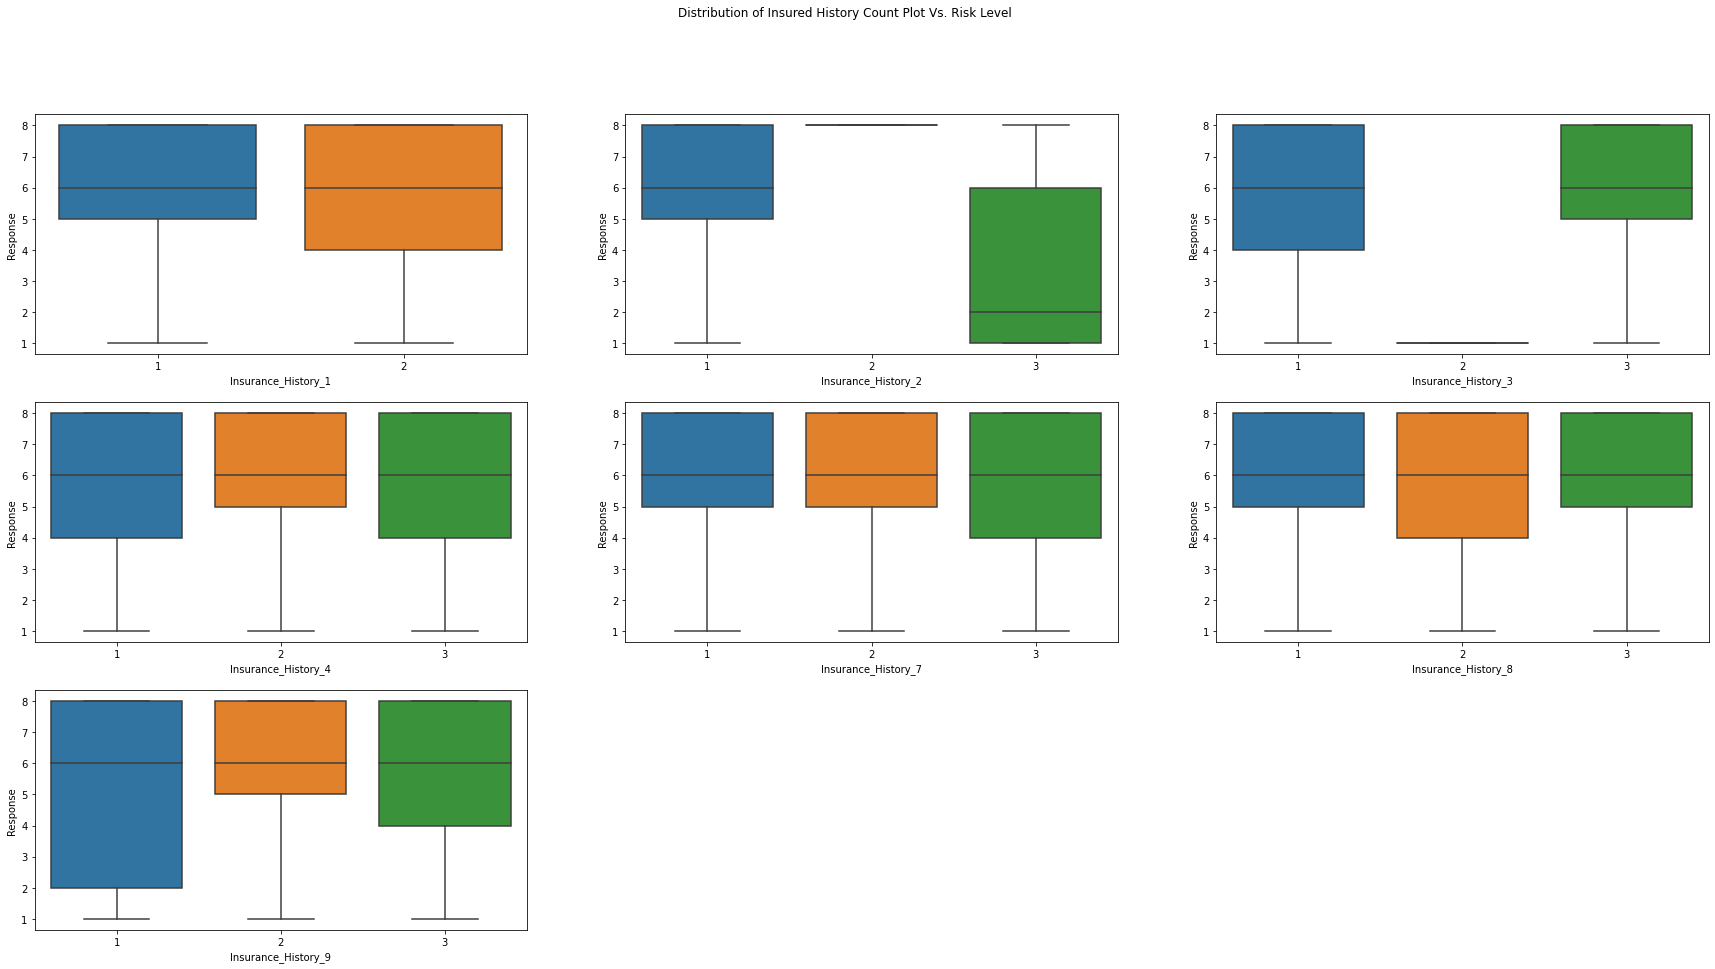

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
for col, an_axes in zip(insure_hist_col, ax.flatten()):
    sns.boxplot(data=basic_train, x=col,y='Response',ax=an_axes)
plt.delaxes(ax[2][1])
plt.delaxes(ax[2][2])
plt.suptitle('Distribution of Insured History Count Plot Vs. Risk Level');

# Family history 1-5 : A set of normalized variables relating to the family history of the applicant.

In [49]:
pd.unique(basic_train['Family_Hist_1'])

array([2, 3, 1], dtype=int64)

In [50]:
basic_train

,Id,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,...,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Response
0,2,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.00000,3,...,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,8
1,5,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.00000,2,...,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,4
2,6,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.00000,2,...,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,8
3,7,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.00000,3,...,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,8
4,8,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.00000,2,...,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,0.074627,0.709091,0.320084,0.519103,0.020,1,3,0.00000,3,...,NaN,3,2,3,3,0.217391,NaN,0.197183,NaN,4
59377,79143,0.432836,0.800000,0.403766,0.551119,0.100,9,1,0.00001,2,...,0.000267,1,3,2,3,0.565217,NaN,0.478873,NaN,7
59378,79144,0.104478,0.745455,0.246862,0.360969,0.035,9,1,0.00000,2,...,NaN,3,2,3,3,0.173913,NaN,0.126761,NaN,8
59379,79145,0.507463,0.690909,0.276151,0.462452,0.038,9,1,NaN,3,...,NaN,3,2,3,2,NaN,0.372549,0.704225,NaN,8


In [51]:
Family_hist_col = basic_train.iloc[:,27:32]
Family_hist_col

,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Response
0,NaN,0.598039,NaN,0.526786,8
1,0.188406,NaN,0.084507,NaN,4
2,0.304348,NaN,0.225352,NaN,8
3,0.420290,NaN,0.352113,NaN,8
4,0.463768,NaN,0.408451,NaN,8
...,...,...,...,...,...
59376,0.217391,NaN,0.197183,NaN,4
59377,0.565217,NaN,0.478873,NaN,7
59378,0.173913,NaN,0.126761,NaN,8
59379,NaN,0.372549,0.704225,NaN,8


Text(0, 0.5, 'Frequency')

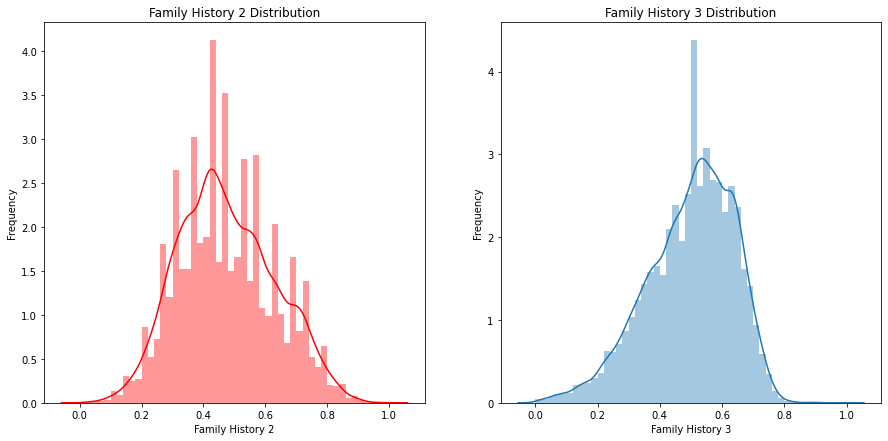

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,7))


sns.distplot(basic_train['Family_Hist_2'],ax=ax[0],color='red')
ax[0].set_title("Family History 2 Distribution")
ax[0].set_xlabel("Family History 2")
ax[0].set_ylabel("Frequency")

sns.distplot(basic_train['Family_Hist_3'],ax=ax[1])
ax[1].set_title("Family History 3 Distribution")
ax[1].set_xlabel("Family History 3")
ax[1].set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

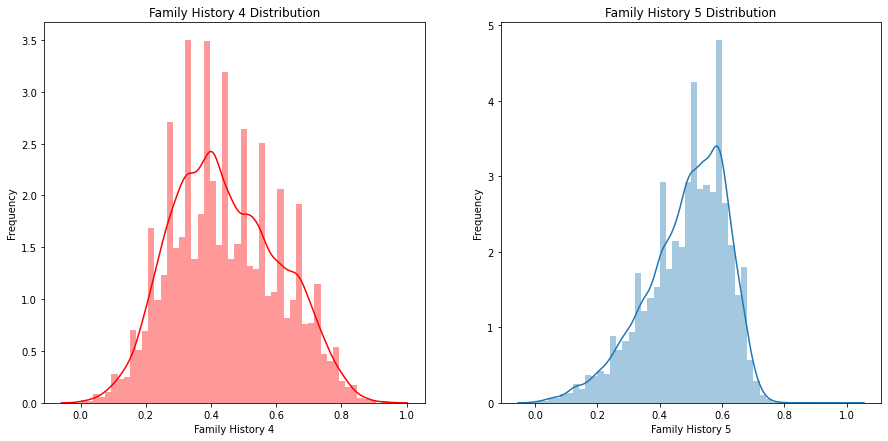

In [53]:
Family_Hist_2fig, ax = plt.subplots(1,2,figsize=(15,7))


sns.distplot(basic_train['Family_Hist_4'],ax=ax[0],color='red')
ax[0].set_title("Family History 4 Distribution")
ax[0].set_xlabel("Family History 4")
ax[0].set_ylabel("Frequency")

sns.distplot(basic_train['Family_Hist_5'],ax=ax[1])
ax[1].set_title("Family History 5 Distribution")
ax[1].set_xlabel("Family History 5")
ax[1].set_ylabel("Frequency")

Text(0.5, 0, 'Family History')

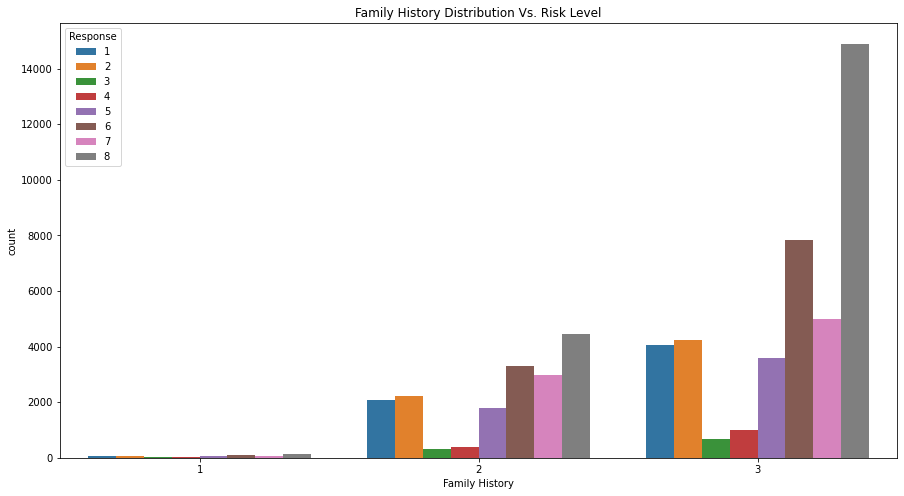

In [54]:
#it is a categorical variable
plt.figure(figsize=(15,8))
sns.countplot(data=df_train, x='Family_Hist_1', hue='Response');
plt.title('Family History Distribution Vs. Risk Level')
plt.xlabel("Family History")

In [55]:
#Product info 1 To 7

In [56]:
product_col

['Product_Info_1',
 'Product_Info_2',
 'Product_Info_3',
 'Product_Info_4',
 'Product_Info_5',
 'Product_Info_6',
 'Product_Info_7']

In [57]:
product_train=df_train[product_col]
product_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product_Info_1  59381 non-null  int64  
 1   Product_Info_2  59381 non-null  object 
 2   Product_Info_3  59381 non-null  int64  
 3   Product_Info_4  59381 non-null  float64
 4   Product_Info_5  59381 non-null  int64  
 5   Product_Info_6  59381 non-null  int64  
 6   Product_Info_7  59381 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.2+ MB


In [58]:
pd.unique(product_train['Product_Info_3'])

array([10, 26, 21, 31, 29, 37, 15, 36,  8,  4, 30, 11, 23, 28, 13,  9,  6,
       33, 32,  3, 18,  2, 22, 17, 38, 19, 34, 12, 24, 20,  1, 16,  5, 27],
      dtype=int64)

Text(-9.075000000000003, 0.5, 'Frequency')

<Figure size 864x576 with 0 Axes>

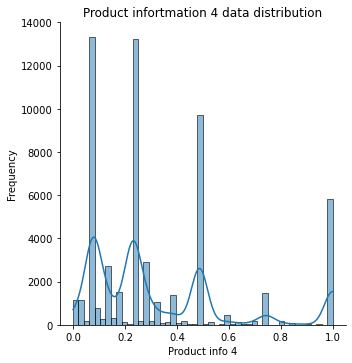

In [59]:
plt.figure(figsize=(12,8))
sns.displot(x=product_train['Product_Info_4'],kde=True)
plt.title('Product infortmation 4 data distribution')
plt.xlabel('Product info 4')
plt.ylabel('Frequency')

In [60]:
Product_info_cat=['Product_Info_1','Product_Info_2','Product_Info_3','Product_Info_5','Product_Info_6','Product_Info_7']
 

Text(0.5, 0.98, 'Distribution of Product Information Count Plot')

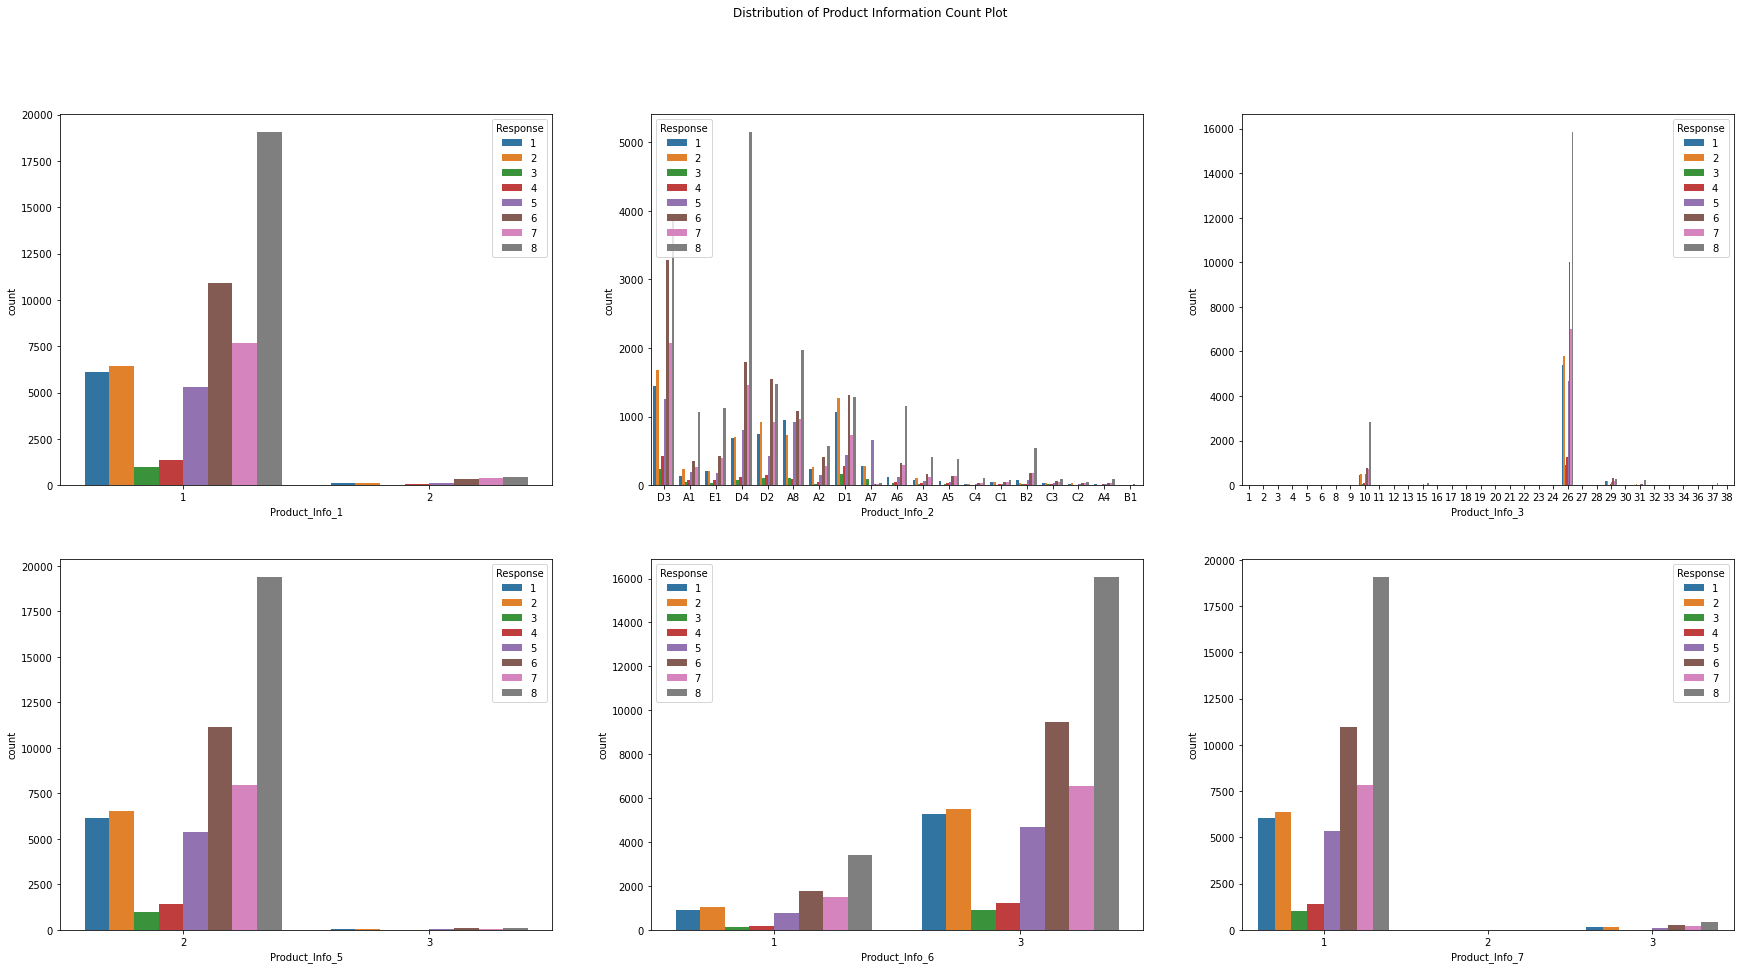

In [61]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))
for col, an_axes in zip(Product_info_cat, ax.flatten()):
    sns.countplot(data=df_train, x=col,hue='Response',ax=an_axes)
plt.suptitle('Distribution of Product Information Count Plot')

In [62]:
##Medical history 1 to 41 variable 

In [63]:
medical_his_train=df_train[medical_his_col]
medical_his_train

,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,...,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41
0,4.0,112,2,1,1,3,2,2,1,3,...,3,1,3,1,2,2,1,3,3,3
1,5.0,412,2,1,1,3,2,2,1,3,...,3,3,1,1,2,2,1,3,3,1
2,10.0,3,2,2,1,3,2,2,2,3,...,3,3,3,1,3,2,1,3,3,1
3,0.0,350,2,2,1,3,2,2,2,3,...,3,3,3,1,2,2,1,3,3,1
4,NaN,162,2,2,1,3,2,2,2,3,...,3,3,3,1,3,2,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,0.0,261,2,1,1,3,2,2,2,3,...,3,3,3,1,2,2,1,3,3,3
59377,24.0,491,2,2,1,3,2,2,2,3,...,3,3,3,1,3,2,1,3,3,1
59378,NaN,162,2,2,1,3,2,2,2,3,...,3,3,1,1,3,2,1,3,3,1
59379,0.0,16,2,1,1,3,2,2,2,3,...,3,1,3,1,2,2,1,3,3,3


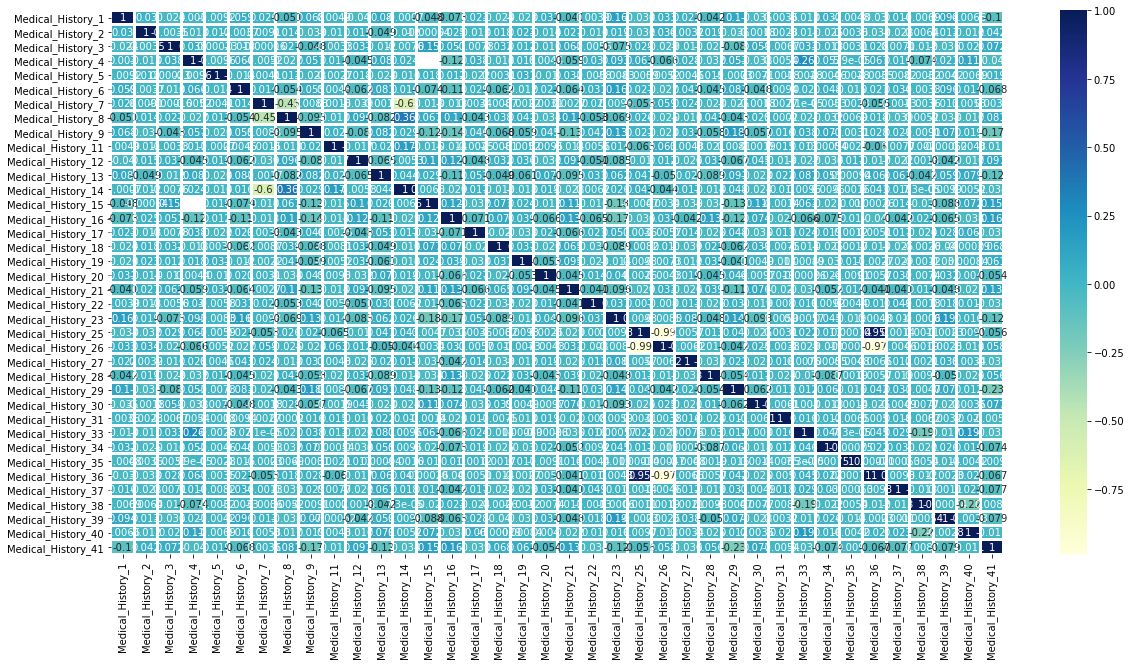

In [64]:
plt.figure(figsize=(20,10))
sns.heatmap(data=medical_his_train.corr(),cmap='YlGnBu',annot=True,linewidths=2)
plt.show()

In [65]:
pd.unique(medical_his_train['Medical_History_41'])

array([3, 1, 2], dtype=int64)

Only Medical history 2 contain numerical data.All the others are categorical data. Also the medical history 36 has high correlation.so we can drop this feature.

In [66]:
#dropping Medical_History_41 columns as it will affect the performance of the model
#df_train.drop('Medical_History_36',axis=1,inplace=True)

In [67]:
df_train.shape

(59381, 125)

Text(0.5, 0.98, 'Distribution of Product Information Count Plot')

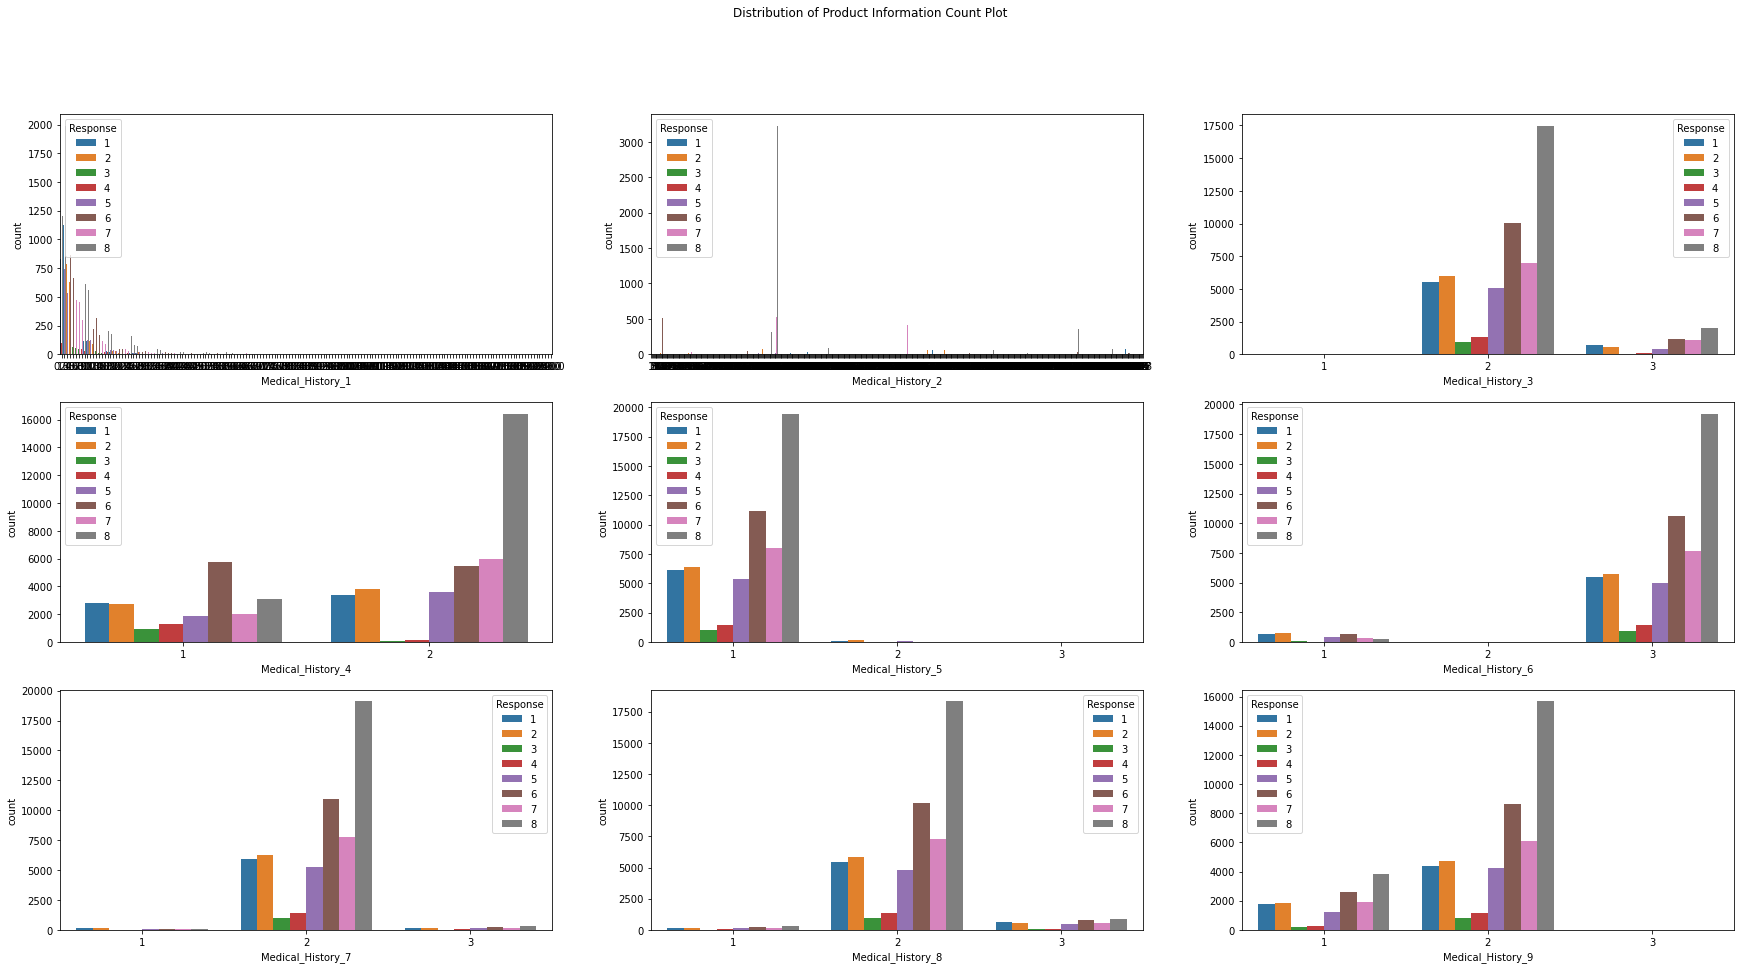

In [68]:
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
for col, an_axes in zip(medical_his_col, ax.flatten()):
    sns.countplot(data=medical_his_train, x=col,hue=df_train['Response'],ax=an_axes)
plt.suptitle('Distribution of Product Information Count Plot')

1.As per above graph all the medical history have 3 category except medical history 4 which has only 2 category.but most of the categories have less data.Also the response for 8 is high for all medical history. 2.Medical history 1 and 2 contain numerical data.



# Correlation to remove the feature having correlation greater than 0.8

In [69]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [70]:
corr_features = correlation(df_train, 0.8)
len(set(corr_features))

13

In [71]:
corr_features

{'BMI',
 'Family_Hist_2',
 'Family_Hist_4',
 'Insurance_History_4',
 'Insurance_History_7',
 'Insurance_History_9',
 'Medical_History_26',
 'Medical_History_36',
 'Medical_Keyword_11',
 'Medical_Keyword_15',
 'Medical_Keyword_23',
 'Medical_Keyword_30',
 'Medical_Keyword_48'}

In [72]:
#df_train.drop(labels=corr_features, axis=1, inplace=True)

In [73]:
##Medical keywords column

In [74]:
df_train.shape

(59381, 125)

In [75]:
# find the index no 
index_no = df_train.columns.get_loc('Medical_Keyword_1')
index_no

76

In [76]:
index_no = df_train.columns.get_loc('Medical_Keyword_47')
index_no

122

In [77]:
#Dropping dummy variables 
df_train.drop(df_train.iloc[:,76:124],axis=1,inplace=True)

In [78]:
df_train.shape

(59381, 77)

# Dealing with Numerical Columns

In [79]:
# Numerical columns
df_train.select_dtypes(include=['int64', 'float64']).columns

Index(['Id', 'Product_Info_1', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_2',
       'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5',
       'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3',
       'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7',
       'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3',
       'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7',
       'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1',
       'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5',
       'Medical_History_1', 'Medical_History_2', 'Medical_History_3',
       'Medical_History_4', 'Medical_History_5', 'Medical_History_6',
       'Medical_History_7', 'Medical_History_8', 'Medical_History_9',
       'Medical_History_11', 'Medical_History_12', 'Medical_Hi

In [80]:
len(df_train.select_dtypes(include=['int64', 'float64']).columns)

76

In [81]:
## Dealing with Categorical Columns

In [82]:
df_train.select_dtypes(include='object').columns

Index(['Product_Info_2'], dtype='object')

In [83]:
pd.unique(df_train['Product_Info_2'])

array(['D3', 'A1', 'E1', 'D4', 'D2', 'A8', 'A2', 'D1', 'A7', 'A6', 'A3',
       'A5', 'C4', 'C1', 'B2', 'C3', 'C2', 'A4', 'B1'], dtype=object)

# Missing value imputation

In [84]:
#For numerical value imputation

df_train.fillna(df_train.mean(),inplace=True)

# converting Categorical data into numerical using label encoding

In [85]:
from sklearn.preprocessing import LabelEncoder

In [86]:
le=LabelEncoder()
df_train['Product_Info_2']=le.fit_transform(df_train['Product_Info_2'])

In [87]:
df_train.shape

(59381, 77)

# Splitting data into train and test

In [88]:
# Seperate Features and Target
X= df_train.drop(columns = ['Response'], axis=1)
y= df_train['Response']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =111)

In [90]:
Counter(y_train)

Counter({4: 1121,
         5: 4308,
         8: 15580,
         6: 9015,
         1: 5007,
         7: 6430,
         3: 827,
         2: 5216})

# Scaling the numeric values in the dataset

In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler=StandardScaler()
scaler.fit(df_train)

StandardScaler()

In [93]:
scaled_data=scaler.transform(df_train)

In [94]:
scaled_data

array([[-1.7314931 , -0.16452547,  0.6452571 , ...,  0.12835868,
         1.45597254,  0.96188188],
       [-1.73136161, -0.16452547, -2.30903124, ...,  0.12835868,
        -0.68683942, -0.66624408],
       [-1.73131778, -0.16452547,  1.01454314, ...,  0.12835868,
        -0.68683942,  0.96188188],
       ...,
       [ 1.73726005, -0.16452547,  1.01454314, ...,  0.12835868,
        -0.68683942,  0.96188188],
       [ 1.73730388, -0.16452547,  0.46061408, ...,  0.12835868,
         1.45597254,  0.96188188],
       [ 1.73734771, -0.16452547, -1.01653009, ...,  0.12835868,
        -0.68683942,  0.55485039]])

# Handling imbalance classes

In [95]:
from imblearn.over_sampling import SMOTE

In [96]:
smote = SMOTE() 

In [97]:
X, y = smote.fit_resample(X_train, y_train)

In [98]:
Counter(y)

Counter({4: 15580,
         5: 15580,
         8: 15580,
         6: 15580,
         1: 15580,
         7: 15580,
         3: 15580,
         2: 15580})

In [99]:
X_train.shape

(47504, 76)

# PCA to Speed up Machine Learning Algorithms (Logistic Regression)

In [100]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [102]:
explained_ratio = np.cumsum(pca.explained_variance_ratio_*100)

In [103]:
explained_ratio

array([  6.9983163 ,  11.62846192,  15.77925337,  19.66972232,
        22.48922537,  25.05356696,  27.41231777,  29.62830346,
        31.75142334,  33.79907359,  35.69736418,  37.43057121,
        39.04343369,  40.61316874,  42.15360708,  43.57228357,
        44.98285166,  46.36640232,  47.70946481,  49.05135966,
        50.37364634,  51.69234954,  52.99978311,  54.30067199,
        55.60058497,  56.88581431,  58.16808546,  59.44243247,
        60.71011866,  61.96838331,  63.22398009,  64.47152168,
        65.71385596,  66.94279372,  68.16930189,  69.38761841,
        70.60365633,  71.8089018 ,  73.00229574,  74.19462454,
        75.37338391,  76.54130274,  77.70514602,  78.85403965,
        79.9906739 ,  81.1172038 ,  82.23318857,  83.34357597,
        84.42920441,  85.49630036,  86.53758281,  87.57441217,
        88.5612832 ,  89.53096175,  90.48689811,  91.40792969,
        92.31572947,  93.21272133,  94.06614116,  94.83571075,
        95.5602081 ,  96.25024961,  96.87761539,  97.50

In [104]:
len(explained_ratio[explained_ratio< 99])

67

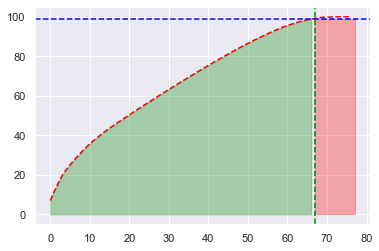

In [105]:
plt.figure()
sns.set()
sns.lineplot(np.arange(len(explained_ratio)),explained_ratio,linestyle="--",color='red')
plt.axhline(99,linestyle='--',color='blue')
plt.axvline(67,linestyle="--",color='green')
plt.fill_between([67,77], [99,99], color="red", alpha=0.3)
plt.fill_between(np.arange(len(explained_ratio[explained_ratio< 99])), np.array(explained_ratio[explained_ratio< 99]), color="green", alpha=0.3)
plt.show()

In [106]:
pca = PCA(n_components=67)

In [107]:
pca.fit(scaled_data)

PCA(n_components=67)

In [108]:
final_df = pca.transform(scaled_data)

In [109]:
final_df.shape

(59381, 67)

In [110]:
final_df

array([[ 2.12333426, -3.25563113, -1.17696757, ...,  0.26637983,
         0.01220711,  0.49174736],
       [-1.11617849, -2.05642189, -1.19482501, ...,  0.13622448,
        -0.02199891,  0.05890461],
       [-4.20278656,  0.66680111, -0.21055352, ...,  0.40092021,
         0.01201466,  0.0916866 ],
       ...,
       [-4.23731065,  0.47335185, -0.35842303, ...,  0.12126602,
         0.02761499,  0.20859458],
       [-1.32429979, -1.67684037,  1.42151544, ..., -1.48315529,
        -0.03347475, -0.56515107],
       [-1.22161538,  1.4294172 ,  1.12916444, ..., -0.1262055 ,
         0.00485006, -0.06164366]])

# Logistic Regression

In [111]:
#model_log= LogisticRegression(multi_class='ovr',solver = 'lbfgs')
model_log= LogisticRegression(C=100,multi_class='ovr',random_state=111, solver='newton-cg')
model_log.fit(X_train, y_train)

LogisticRegression(C=100, multi_class='ovr', random_state=111,
                   solver='newton-cg')

In [112]:
y_pred_train = model_log.predict(X_train) # predicting on Training dataset
y_pred_test = model_log.predict(X_test) # Predicting on Test Data / Unseen data

In [113]:
# use the model to make predictions with the test data
y_pred_train=model_log.predict(X_train)
y_pred_test = model_log.predict(X_test)
# how did our model perform?
accuracy = metrics.accuracy_score(y_test, model_log.predict(X_test))
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.49


In [114]:
classification_report_train=metrics.classification_report(y_train,y_pred_train)
classification_report_test=metrics.classification_report(y_test,y_pred_test)
print(classification_report_train)
print(classification_report_test)

              precision    recall  f1-score   support

           1       0.39      0.27      0.32      5007
           2       0.35      0.17      0.23      5216
           3       0.51      0.28      0.36       827
           4       0.49      0.60      0.54      1121
           5       0.41      0.24      0.30      4308
           6       0.39      0.41      0.40      9015
           7       0.38      0.25      0.30      6430
           8       0.60      0.90      0.72     15580

    accuracy                           0.50     47504
   macro avg       0.44      0.39      0.40     47504
weighted avg       0.46      0.50      0.46     47504

              precision    recall  f1-score   support

           1       0.37      0.26      0.30      1200
           2       0.36      0.17      0.23      1336
           3       0.45      0.26      0.33       186
           4       0.52      0.63      0.57       307
           5       0.41      0.23      0.29      1124
           6       0.39 

In [115]:
param_gird = {
    'C':[0.1,0.01,2,5],
    'class_weight':['balanced',None]
}  ## Parameter grid to explore Best value for Hyper Parameter

In [116]:
log_Grid = GridSearchCV(LogisticRegression(),param_grid=param_gird,scoring = 'f1_micro',cv = 5)

# Training our Random Forest Classifier

In [ ]:
### Training our Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [118]:
rndm_clf = RandomForestClassifier(n_estimators=250,max_depth =11,min_samples_leaf=4,min_samples_split=3, random_state=111)
rndm_clf.fit(X_train,y_train)
y_predict_train = rndm_clf.predict(X_train)
y_predict_test = rndm_clf.predict(X_test)
print('Train: ')
print(metrics.classification_report(y_train,y_predict_train))
print('Test: ')
print(metrics.classification_report(y_test,y_predict_test))

Train: 
              precision    recall  f1-score   support

           1       0.84      0.30      0.44      5007
           2       0.77      0.30      0.43      5216
           3       0.82      0.51      0.63       827
           4       0.64      0.76      0.69      1121
           5       0.71      0.59      0.64      4308
           6       0.50      0.66      0.57      9015
           7       0.53      0.32      0.40      6430
           8       0.64      0.93      0.76     15580

    accuracy                           0.62     47504
   macro avg       0.68      0.54      0.57     47504
weighted avg       0.64      0.62      0.59     47504

Test: 
              precision    recall  f1-score   support

           1       0.45      0.14      0.21      1200
           2       0.52      0.18      0.26      1336
           3       0.64      0.43      0.51       186
           4       0.62      0.74      0.67       307
           5       0.62      0.53      0.57      1124
         

# Gradient Boosting Classifier

In [119]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [120]:
clf_g=GradientBoostingClassifier(n_estimators=180,max_depth=9,learning_rate=0.01,random_state=111) 
clf_g.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=9, n_estimators=180,
                           random_state=111)

In [121]:
print('Train: ') 
print(metrics.classification_report(y_train,clf_g.predict(X_train)))
print('Test: ')
print(metrics.classification_report(y_test,clf_g.predict(X_test)))

Train: 
              precision    recall  f1-score   support

           1       0.94      0.45      0.61      5007
           2       0.88      0.45      0.60      5216
           3       0.93      0.76      0.84       827
           4       0.78      0.84      0.81      1121
           5       0.79      0.68      0.73      4308
           6       0.63      0.67      0.65      9015
           7       0.57      0.57      0.57      6430
           8       0.71      0.94      0.81     15580

    accuracy                           0.71     47504
   macro avg       0.78      0.67      0.70     47504
weighted avg       0.73      0.71      0.69     47504

Test: 
              precision    recall  f1-score   support

           1       0.44      0.18      0.25      1200
           2       0.47      0.22      0.30      1336
           3       0.54      0.40      0.46       186
           4       0.64      0.71      0.67       307
           5       0.63      0.54      0.58      1124
         

By performing hyperparammeter tunning .here we can see the model performance is increased.Gradient boosting
we get 57% accuracy with 0.50% F1 score.This model gives a better performance compare to before.

In [122]:
param_grid = {
     'n_estimators':[100,150,200],
    'max_depth':[5,8,10],
    'learning_rate':[0.1,0.01,0.2],
    'min_samples_leaf':[2,3,5],
    'min_samples_split':[2,3,5]
}


In [123]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [124]:
gf_random = GridSearchCV(estimator = clf_g,param_grid= param_grid, cv = 5,scoring='f1_micro')


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)

In [ ]:
print('Train: ')
print(metrics.classification_report(y_train,classifier.predict(X_train)))
print('Test: ')
print(metrics.classification_report(y_test,classifier.predict(X_test)))

We biuld a model Using K-Nearest Neighbor(KNN) Algorithm but it gives a very poor performance.

In [ ]:
from sklearn.svm import SVC

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [ ]:
print('Train: ')
print(metrics.classification_report(y_train,svclassifier.predict(X_train)))
print('Test: ')
print(metrics.classification_report(y_test,svclassifier.predict(X_test)))

# NAive Bayes Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_gau = GaussianNB()
model_gau.fit(X_train, y_train)

In [ ]:
print('Train: ')
print(metrics.classification_report(y_train,model_gau.predict(X_train)))
print('Test: ')
print(metrics.classification_report(y_test,model_gau.predict(X_test)))

# Conclusion:

# MODEL PERFORMANCE

1.Machine learning algorithms named Logistic regression, Decision tree classifier, Random forest classifier, Adaboost classifier, XG Boost classifier, Support Vector Classification, K-Nearest Neighbor(KNN)were used. 2.Above classifications were performed to Predict whether an application will be high risk or low risk based on attributes.. 3.Among all the classification algorithms that were used, Gradient boosting classifier had performed better than all remaining classifiers. A best score of 0.57% accuracy with 0.50 F1 Score was achieved using Gradient boosting classifier.